# 04-Transfer learning with Tensorflow Part 1: Feature Extension
We've built a bunch of convolutional neural networks from scratch and they all seem to be learning, however, there is still plenty of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called transfer learning, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.
What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.



What we're going to cover
We're going to go through the following with TensorFlow:

* Introduce transfer learning (a way to beat all of our old self-built models)
* Using a smaller dataset to experiment faster (10% of training samples of 10 * classes of food)
* Build a transfer learning feature extraction model using TensorFlow Hub
* Introduce the TensorBoard callback to track model training results
* Compare model results using TensorBoard


In [2]:
# are you using gpu
!nvidia-smi


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Downloading and becoming one with data

In [3]:
# get data 10% of (10 food classes all data)

import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()


--2022-05-03 11:46:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   167MB/s    in 1.0s    

2022-05-03 11:46:05 (167 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# how manu directory and file have in each of label
import os
for dirpath ,dirname,filename in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirname)} of directory and {len(filename)} image in '{dirpath}' ")

There are 2 of directory and 0 image in '10_food_classes_10_percent' 
There are 10 of directory and 0 image in '10_food_classes_10_percent/train' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/grilled_salmon' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/steak' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/sushi' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/chicken_wings' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/ice_cream' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/pizza' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/chicken_curry' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/hamburger' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/train/ramen' 
There are 0 of directory and 75 image in '10_food_classes_10_percent/trai

### Creating data loader (preprare data)
Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.



In [5]:
# set up inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCH = 5

# inialize ImageDataGenerator 
train_datagen_10_percent = ImageDataGenerator(rescale=1/255.)
test_datagen_10_percent = ImageDataGenerator(rescale=1/255.)

print("Training Image: ")
train_data_10_percent = train_datagen_10_percent.flow_from_directory(directory=train_dir,
                                                                    target_size=IMAGE_SHAPE,
                                                                    batch_size=BATCH_SIZE,
                                                                    class_mode='categorical')

print("Testing Image: ")
test_data_10_percent = test_datagen_10_percent.flow_from_directory(directory=test_dir,
                                                                   target_size=IMAGE_SHAPE,
                                                                   batch_size=BATCH_SIZE,
                                                                   class_mode='categorical')

Training Image: 
Found 750 images belonging to 10 classes.
Testing Image: 
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model trains)
Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is callbacks.

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* **Experiment tracking with TensorBoard -** log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* **Model checkpointing -** save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* **Early stopping -** leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.


In [6]:
# Create tensorbard callback (functionized because need to create a new one for each model)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/"+ experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir
    )
    print(f"Saving TensorBoard log files to : {log_dir}")
    return tensorboard_callback

### Creating models using TensorFlow Hub
In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1



In fact, we're going to use two models from TensorFlow Hub:

* ResNetV2 - a state of the art computer vision model architecture from 2016.
* EfficientNet - a state of the art computer vision architecture from 2019.


In [7]:
# let's compare two model each other
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [8]:
import tensorflow as tf


In [9]:
print(tf.__version__)

2.8.0


In [10]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("10_food_classes_10_percent/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [11]:
# import importent depandecies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [12]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [13]:
resnet_model = create_model(model_url=resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [14]:
# compile the model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [15]:
# fit the model 
res_net_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20220503-114625
Epoch 1/5
24/24 [==============================] - 391s 17s/step - loss: 1.9619 - accuracy: 0.3253 - val_loss: 1.2125 - val_accuracy: 0.6168
Epoch 2/5
24/24 [==============================] - 380s 16s/step - loss: 0.9316 - accuracy: 0.7147 - val_loss: 0.8418 - val_accuracy: 0.7276
Epoch 3/5
24/24 [==============================] - 377s 16s/step - loss: 0.6419 - accuracy: 0.8187 - val_loss: 0.7823 - val_accuracy: 0.7388
Epoch 4/5
24/24 [==============================] - 409s 18s/step - loss: 0.4918 - accuracy: 0.8720 - val_loss: 0.6978 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 409s 18s/step - loss: 0.3931 - accuracy: 0.9053 - val_loss: 0.6814 - val_accuracy: 0.7680


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.


In [16]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "halper.py" and import it when you need it...
import matplotlib.pyplot as plt
def plot_loss_curve(history):
    """
    Return sparate loss curves for training and validation metrics
    
    Args:
      history: Tensorflow history object
    Return: 
      Plots of training/validation loass and accuracy metrics
      
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epoch = range(len(history.history["loss"]))
    
    # plot loss
    plt.plot(epoch,loss,label="training loss")
    plt.plot(epoch,val_loss,label="val loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend();
    
    # plot accuracy
    plt.figure()
    plt.plot(epoch,accuracy,label="training accuracy")
    plt.plot(epoch,val_accuracy,label="val accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();
    

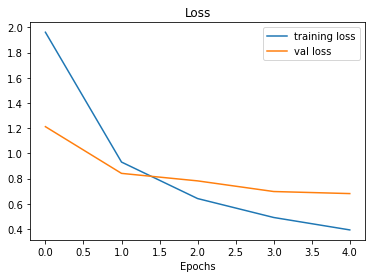

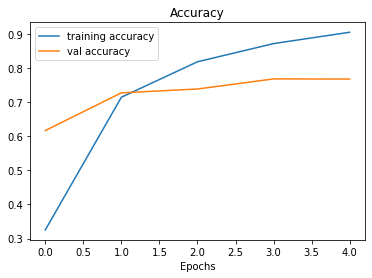

In [17]:
plot_loss_curve(res_net_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [18]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                 num_classes=train_data_10_percent.num_classes)

In [19]:
# compilet the model
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

In [ ]:
# fit the model
efficient_net_history = efficientnet_model.fit(train_data_10_percent,
                      epochs=EPOCH,
                      steps_per_epoch = len(train_data_10_percent),
                      validation_data = test_data_10_percent,
                      validation_steps = len(test_data_10_percent),
                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnet_b0")])

Saving TensorBoard log files to : tensorflow_hub/efficientnet_b0/20220503-122056
Epoch 1/5
24/24 [==============================] - 154s 6s/step - loss: 1.8848 - accuracy: 0.4213 - val_loss: 1.3155 - val_accuracy: 0.7328
Epoch 2/5
24/24 [==============================] - 142s 6s/step - loss: 1.0838 - accuracy: 0.7600 - val_loss: 0.8655 - val_accuracy: 0.8336


In [ ]:
plot_loss_curve(efficient_net_history)

In [ ]:
# check two model summary
resnet_model.summary()

In [ ]:
efficientnet_model.summary()

### predict our custom image

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img


In [ ]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
pizza = load_and_prep_image(filename="drive/MyDrive/04_transfer_learning_model_prediction_image/pizza_image.jpg")
pizza.shape

In [ ]:
# first see resnet  model predication
pred_and_plot(resnet_model,filename="drive/MyDrive/04_transfer_learning_model_prediction_image/pizza_image.jpg",class_names=class_names)

In [ ]:
class_names

In [ ]:
pred_and_plot(efficientnet_model,filename="drive/MyDrive/04_transfer_learning_model_prediction_image/pizza_image.jpg",class_names=class_names)

### Different type of transfer learning.

* **"As is"** Transfer learning  - using as existing model with no changes so ever (e.g using ImageNet model on  1000 ImageNet classes ,none of won
* ** "Feature Extrection "** Transfer learning  - Using prealearned pattern of an a existing model (e.g EfficientNetB0 trained on ImageNet ) and adjust the output layer for  your won problem (e.g 1000 classes > 10 classes food)
* **Fine-tunning** Transfer Learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)
                                                                    

### Comparing our model result using **(TensorBoard)**

 > **🔑Note**: When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to [TensorBoard.dev](https://tensorboard.dev/).

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot